# Training SVC

## Distribution of Data

Need to make sure that the training data is normalized and has almost equal number of Car and Non-Car samples

Total Cars: 8792
Total Non-Cars: 8968
Total Data: 17760
Total Training: 14208
Total Test: 3552


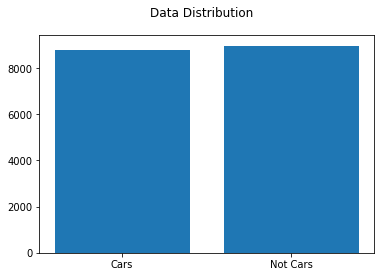

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

cars = glob.glob('./vehicles/**/*.png', recursive=True)
notcars = glob.glob('./non-vehicles/**/*.png', recursive=True)

#cars = glob.glob('./vehicles_smallset/**/*.jpeg', recursive=True)
#notcars = glob.glob('./non-vehicles_smallset/**/*.jpeg', recursive=True)

count = len(cars) + len(notcars)

print('Total Cars:', len(cars))
print('Total Non-Cars:', len(notcars))
print('Total Data:', count)
print('Total Training:', int(count * 0.8))
print('Total Test:', int(count * 0.2))

data = [len(cars), len(notcars)]
index = np.arange(2)
plt.bar(index, data)
plt.xticks(index, ('Cars', 'Not Cars'))
plt.suptitle('Data Distribution')
plt.show()

## Common Functions

## Color Space Choice

In [ ]:
from lesson_functions import *

color_space = 'LAB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

def display_random(filenames, n_samples):
    f, ax = plt.subplots(n_samples, 4, figsize=(15,15))
    f.suptitle(color_space + " Color Space", fontsize=20)

    indices = np.random.choice(len(filenames), n_samples, replace=False)
    
    for i in range(n_samples):
        index = indices[i]
        img = load_image(filenames[index], color_space)
        rgb = load_image(filenames[index], 'RGB')

        ax[i,0].imshow(rgb)
        ax[i,0].set_title('Original ({})'.format(index))

        for j in range(3):
            ax[i,1 + j].imshow(img[:,:,j], cmap='gray')
            ax[i,1 + j].set_title(color_space[j] + ' Channel')

display_random(cars, 5)
display_random(notcars, 5)
plt.show()

## Hog Test Sample

In [ ]:
orient = 12
pix_per_cell = 16
cell_per_block = 4

n_samples = 5

def show_hog(title, filenames):
    indices = np.random.choice(len(filenames), n_samples)
    
    f, ax = plt.subplots(n_samples, 3, figsize=(10,21))
    f.suptitle(title, fontsize=20)

    for i in range(n_samples):
        index = indices[i]

        lab = load_image(filenames[index], color_space)
        L = lab[:,:,0]
        B = lab[:,:,1]
        
        _, hog_img_l = get_hog_features(L, orient=orient, pix_per_cell=pix_per_cell, 
                                        cell_per_block=cell_per_block, vis=True)
                                        
        _, hog_img_b = get_hog_features(B, orient=orient, pix_per_cell=pix_per_cell, 
                                        cell_per_block=cell_per_block, vis=True)
        
        img = load_image(filenames[index], 'RGB')
        ax[i,0].imshow(img)
        ax[i,1].imshow(hog_img_l)
        ax[i,2].imshow(hog_img_b)
    
    f.tight_layout()

show_hog('Cars - Hog L,B Channels', cars)
show_hog('Non Cars - Hog L,B Channels', notcars)

plt.show()

## Spatial Features
Shows effects of spatial size, which is just a resize of image and then raveling it

In [ ]:
n_samples = 5

def show_resize(title, filenames):
    indices = np.random.choice(len(filenames), n_samples)
    
    f, ax = plt.subplots(n_samples, 3, figsize=(10,16))
    f.tight_layout()
    f.suptitle(title, fontsize=20)
    f.subplots_adjust(top=0.92)
    
    for i in range(n_samples):
        index = indices[i]

        img = []
        img.append(load_image(filenames[index], 'RGB'))
        img.append(cv2.resize(img[0], (32,32)))
        img.append(cv2.resize(img[0], (16,16)))
        
        for j in range(len(img)):
            ax[i,j].imshow(img[j])
            ax[i,j].set_title(img[j].shape)

show_resize('Cars - Spatial Resize', cars)
show_resize('Non Cars - Spatial Resize', notcars)
plt.show()

## Color Histogram

In [ ]:
n_samples = 5

indices = np.random.choice(len(cars), n_samples)

f, ax = plt.subplots(n_samples, 4, figsize=(10,10))
f.tight_layout()
f.subplots_adjust(top=0.92)

for i in range(n_samples):
    index = indices[i]
    
    color_space = 'LAB'
    
    car_img = load_image(cars[index], color_space)
    notcar_img = load_image(notcars[index], color_space)
    car_features = color_hist(car_img)
    notcar_features = color_hist(notcar_img)

    #  for displaying show RGB on screen
    car_img = load_image(cars[index], "RGB")
    notcar_img = load_image(notcars[index], "RGB")

    ax[i,0].imshow(car_img)
    ax[i,1].plot(car_features)
    ax[i,2].imshow(notcar_img)
    ax[i,3].plot(notcar_features)

plt.show()

## Gradient of Image

In [ ]:
# def show_grad(filenames, index):
#     #gray = load_image(filenames[index], 'GRAY')
#     img = load_image(filenames[index], 'LAB')
#     gray = img[:,:,0]
#     img = cv2.GaussianBlur(gray, (3,3), 0)
    
#     laplacian = cv2.Laplacian(img, cv2.CV_64F)
#     sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
#     sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    
#     f, ax = plt.subplots(1, 4, figsize=(10,5))
#     ax[0].imshow(img, cmap='gray')
#     ax[1].imshow(laplacian, cmap='gray')
#     ax[2].imshow(sobelx, cmap='gray')
#     ax[3].imshow(sobely, cmap='gray')

# def get_laplacian_hog(channel, visualise = False, ravel = False):
#     laplacian = get_laplacian(channel)
#     hog_laplacian = hog(laplacian, orientations=9, 
#                             pixels_per_cell=(8, 8),
#                             cells_per_block=(2, 2), 
#                             transform_sqrt=False, 
#                             visualise=visualise, 
#                             feature_vector=False,
#                             block_norm='L2-Hys')
    
#     if ravel == True:
#         return np.ravel(hog_laplacian)
    
#     return hog_laplacian
    
# def show_laplac(title, filenames):
#     indices = np.random.choice(len(filenames), n_samples)
    
#     f, ax = plt.subplots(n_samples, 3, figsize=(20,16))
#     f.tight_layout()
#     f.suptitle(title, fontsize=20)
#     f.subplots_adjust(top=0.92)

#     orient = 9  # HOG orientations
#     pix_per_cell = 8 # HOG pixels per cell
#     cell_per_block = 2 # HOG cells per block

#     for i in range(n_samples):
#         index = indices[i]
        
#         img = load_image(filenames[index], 'LAB')
#         L = img[:,:,0]

#         _, hog_img_l = get_laplacian_hog(L, visualise=True)

#         laplacian = get_laplacian(L)

#         ax[i,0].imshow(img, cmap='gray')
#         ax[i,0].set_title('L Channel')
#         ax[i,1].imshow(laplacian, cmap='gray')
#         ax[i,1].set_title('Laplacan ' + str(laplacian.shape))
#         ax[i,2].imshow(hog_img_l, cmap='gray')
#         ax[i,2].set_title('Hog ' + str(hog_img_l.shape))

        
# show_laplac('Cars Laplacian', cars)
# show_laplac('Non Cars Laplacian', notcars)

# plt.show()

## Features Chosen

Color Space: LAB

Hog of L and B channels

Hog of LapLacian of L Channel

[Spatial Features 32 x 32][Hog Laplacian of 16x16][Hog of L Channel 32 x 32][Hog of B Channel 32 x 32]

In [2]:
from skimage.feature import hog
import pickle
import os
from lesson_functions import *
import ipy_autoreload

%autoreload 2

orient = 12
pix_per_cell = 16
cell_per_block = 4

spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
    
# pipeline = FeaturePipeLine()
# pipeline.add(SpatialFeature())
# pipeline.add(HogFeature())
# pipeline.add(HistogramFeature())

# pipeline.process(cars)

print('Extracting car features')
car_features = extract_features(cars, color_space='LAB', orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, hog_channel=0,
                               spatial_feat = spatial_feat,
                               hist_feat = hist_feat,
                               hog_feat = hog_feat)

print('Extracting notcar features')
notcar_features = extract_features(notcars, color_space='LAB', orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, hog_channel=0,
                               spatial_feat = spatial_feat,
                               hist_feat = hist_feat,
                               hog_feat = hog_feat)

print('Scaling combined features')
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print('Splitting into training and testing')
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

ERROR:root:Line magic function `%ext_load` not found.
ERROR:root:Line magic function `%autoreload` not found.


Extracting car features
Extracting notcar features
Scaling combined features
Splitting into training and testing
X_train size: (14208, 3936)
y_train size: (14208,)
X_test size: (3552, 3936)
y_test size: (3552,)


## SVM Training

In [3]:
svc = LinearSVC()

t = time.time()
print('Starting training...')

svc.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

t = time.time()
print('Time for accuracy testing', t - t2)


Starting training...
6.12 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.991
Time for accuracy testing 0.05869293212890625


In [ ]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), 
                    xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
